In [2]:
import pandas as pd
from torch import optim
import torch
import matplotlib.pyplot as plt
import warnings
import numpy as np
import random
warnings.filterwarnings("ignore")

from dataloader import getDNNData, getUnscaledData
from models import ArbFreeDNN, train_DNN, eval_DNN

In [3]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 120
LAYERS = [128, 128, 128, 128]
ARB_MULT = 1.0

In [4]:
DNN = ArbFreeDNN(layers=LAYERS)
optimizer = optim.Adam(DNN.parameters(), lr=LEARNING_RATE)
dnn_data = getDNNData(section='train', scale=False, ivs_path='data/R2_STD_IVS_DFW.pkl', batch_size=1, scaler_id=DNN.getID())
##loss_train, re_loss_train, cal_loss_train, but_loss_train = train_DNN(num_epochs=NUM_EPOCHS, model=DNN, dataloader=dnn_data, optimizer=optimizer, logging_interval=100, arb_mult=ARB_MULT)
#plt.plot(loss_train)
#plt.show()

In [7]:
for feature, target in dnn_data:
    feature.requires_grad = True
    print(feature[:, -1].requires_grad)
    print(target.shape)
    break

False
torch.Size([1, 121])


In [ ]:
valid_data = getDNNData(section='valid', scale=True, batch_size=1, scaler_id=DNN.getID())
re_chart, cal_chart, but_chart = eval_DNN(DNN, valid_data)

print(f'RE AVG: {np.array(re_chart).mean()}')
plt.plot(re_chart)
plt.show()

print(f'CAL AVG: {np.array(cal_chart).mean()}')
plt.plot(cal_chart)
plt.show()

print(f'BUT AVG: {np.array(but_chart).mean()}')
plt.plot(but_chart)
plt.show()

scores = pd.read_csv('model_scores/DNN.csv')
entry = pd.DataFrame()
entry['LAYERS'] = [LAYERS]
entry['LR'] = LEARNING_RATE
entry['NUM_EPOCHS'] = NUM_EPOCHS
entry['ARB_MULT'] = ARB_MULT
entry['NUM_LAYERS'] = len(LAYERS)
entry['MEAN_RE_LOSS'] = np.array(re_chart).mean()
entry['STD_RE_LOSS'] = np.array(re_chart).std()
entry['RE_RATIO'] = np.array(re_chart).mean() / np.array(re_chart).std()
entry['MEAN_CAL_LOSS'] = np.array(cal_chart).mean()
entry['STD_CAL_LOSS'] = np.array(cal_chart).std()
entry['CAL_RATIO'] = np.array(cal_chart).mean() / np.array(cal_chart).std()
entry['MEAN_BUT_LOSS'] = np.array(but_chart).mean()
entry['STD_BUT_LOSS'] = np.array(but_chart).std()
entry['BUT_RATIO'] = np.array(but_chart).mean() / np.array(but_chart).std()
entry['FULL'] = True
entry['ID#'] = DNN.getID()
scores = pd.concat([scores, entry], axis=0).reset_index().drop(columns=['index', 'Unnamed: 0'])
scores.to_csv('model_scores/DNN.csv')

torch.save(DNN.state_dict(), f'all_models/DNN_{DNN.getID()}.pt')

In [19]:
compressed = []
count = 0
curr_sum = 0.0
for item in cal_loss_train:
    if count == 560:
        compressed.append(curr_sum / 560)
        curr_sum = 0.0
        count = 0
    else:
        count += 1
        curr_sum += item

In [22]:
len(cal_loss_train) / 2387

120.0

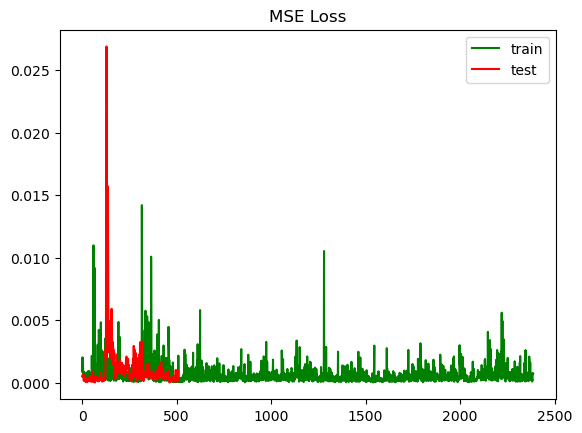

In [35]:
plt.plot(re_loss_train[-2387:], color='g', label='train')
plt.plot(re_chart, color='r', label='test')
plt.legend()
plt.title('MSE Loss')
plt.show()

In [6]:
def compare_two(num: int):
    count = 0
    DNN.eval()
    for feature, _ in valid_data:
        output = DNN(feature)
        if count == num:
            break
        count += 1
    
    feature = getUnscaledData(feature, 'scalers/DNN_scaler_i.pkl')
    output = output.detach()
    output = getUnscaledData(output, 'scalers/DNN_scaler_o.pkl')

    ivs_i = pd.DataFrame(feature[0].reshape(11, 11))  
    ivs_o = pd.DataFrame(output.reshape(11, 11))

    diff = abs(ivs_i - ivs_o)

    fig = plt.figure(40)
    ax = fig.add_subplot(111, projection='3d')

    date_using = ivs_i
    x, y = np.meshgrid(date_using.columns, date_using.index)
    z = date_using.values

    my_cmap = plt.get_cmap('viridis')
    ax.plot_surface(y, x, z, cmap=my_cmap)
    ax.view_init(20, 140) 
    ax.set_xlabel('Time to Expiration', labelpad=7)
    ax.set_ylabel('Moneyness', labelpad=6)
    ax.set_zlabel('Implied Volatility', labelpad=8)
    ax.set_box_aspect(aspect=None, zoom=0.7)
    print(f'Input:')
    plt.show()

    fig = plt.figure(40)
    ax = fig.add_subplot(111, projection='3d')

    date_using = ivs_o
    x, y = np.meshgrid(date_using.columns, date_using.index)
    z = date_using.values

    my_cmap = plt.get_cmap('viridis')
    ax.plot_surface(y, x, z, cmap=my_cmap)
    ax.view_init(20, 140) 
    ax.set_xlabel('Time to Expiration', labelpad=7)
    ax.set_ylabel('Moneyness', labelpad=6)
    ax.set_zlabel('Implied Volatility', labelpad=8)
    ax.set_box_aspect(aspect=None, zoom=0.7)
    print('Output:')
    plt.show()

    fig = plt.figure(40)
    ax = fig.add_subplot(111, projection='3d')

    date_using = diff
    x, y = np.meshgrid(date_using.columns, date_using.index)
    z = date_using.values

    my_cmap = plt.get_cmap('viridis')
    ax.plot_surface(y, x, z, cmap=my_cmap)
    ax.view_init(20, 140) 
    ax.set_xlabel('Time to Expiration', labelpad=7)
    ax.set_ylabel('Moneyness', labelpad=6)
    ax.set_zlabel('Implied Volatility', labelpad=8)
    ax.set_box_aspect(aspect=None, zoom=0.7)
    print(f'Diff:')
    plt.show()

Input:


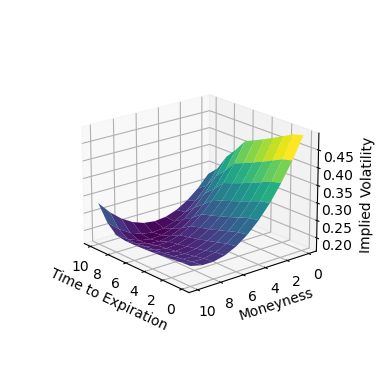

Output:


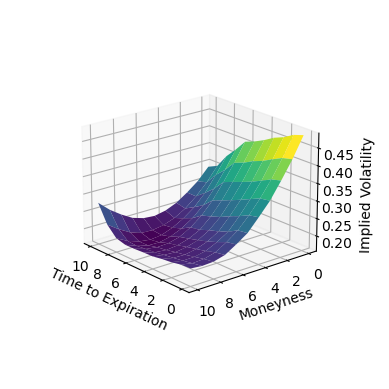

Diff:


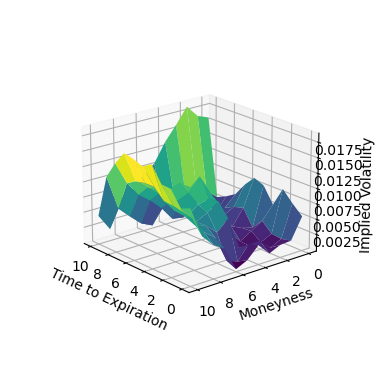

In [12]:
compare_two(230)

In [15]:
count = 0
DNN.eval()
for feature, _ in valid_data:
    output = DNN(feature)
    if count == 0:
        break
    count += 1

feature = getUnscaledData(feature, 'scalers/DNN_scaler_i.pkl')
output = output.detach()
output = getUnscaledData(output, 'scalers/DNN_scaler_o.pkl')

ivs_i = pd.DataFrame(feature[0].reshape(11, 11))  
ivs_o = pd.DataFrame(output.reshape(11, 11)).transpose()

In [17]:
ivs_i

,0,1,2,3,4,5,6,7,8,9,10
0,0.380223,0.325587,0.275497,0.229952,0.188952,0.152498,0.120589,0.093225,0.070407,0.052135,0.038407
1,0.377945,0.323907,0.274413,0.229465,0.189062,0.153205,0.121893,0.095126,0.072905,0.055229,0.042099
2,0.373344,0.320499,0.272199,0.228445,0.189236,0.154572,0.124454,0.098881,0.077854,0.061372,0.049435
3,0.368522,0.316911,0.269844,0.227324,0.189349,0.155919,0.127034,0.102695,0.082901,0.067653,0.056950
4,0.363633,0.313255,0.267423,0.226136,0.189394,0.157198,0.129547,0.106441,0.087881,0.073866,0.064397
5,0.358837,0.309653,0.265015,0.224922,0.189374,0.158371,0.131914,0.110002,0.092636,0.079815,0.071539
6,0.353979,0.305989,0.262544,0.223644,0.189290,0.159482,0.134218,0.113500,0.097328,0.085701,0.078619
7,0.338855,0.294486,0.254662,0.219384,0.188651,0.162464,0.140822,0.123725,0.111174,0.103168,0.099707
8,0.322975,0.282267,0.246104,0.214487,0.187415,0.164889,0.146908,0.133472,0.124582,0.120237,0.120437
9,0.289810,0.256345,0.227425,0.203050,0.183221,0.167937,0.157199,0.151005,0.149358,0.152255,0.159698


In [16]:
ivs_o

,0,1,2,3,4,5,6,7,8,9,10
0,0.406415,0.404766,0.397920,0.394606,0.387677,0.380751,0.374890,0.359018,0.339083,0.307059,0.273700
1,0.346296,0.344077,0.338792,0.334675,0.328284,0.325913,0.321386,0.307203,0.293240,0.268000,0.242399
2,0.290701,0.286034,0.284178,0.280831,0.278350,0.275151,0.271269,0.261540,0.252878,0.234937,0.216450
3,0.238136,0.237848,0.235418,0.234696,0.230165,0.228619,0.227291,0.223375,0.218026,0.207492,0.194955
4,0.193816,0.192308,0.192996,0.190731,0.189984,0.188818,0.190040,0.190853,0.188832,0.185123,0.179876
5,0.154268,0.155270,0.155427,0.154028,0.154495,0.157767,0.157998,0.162819,0.164426,0.167857,0.168901
6,0.126656,0.126807,0.126820,0.126405,0.126900,0.129865,0.132885,0.137845,0.145002,0.156048,0.166303
7,0.102503,0.102616,0.101935,0.103524,0.105447,0.108743,0.111180,0.119079,0.129109,0.147489,0.162320
8,0.082329,0.083250,0.083840,0.086191,0.087914,0.091454,0.096179,0.106681,0.119325,0.143947,0.168713
9,0.067759,0.068601,0.071147,0.073872,0.076536,0.079882,0.085198,0.098274,0.113144,0.138268,0.181361
